# Mini-project \#2 (RNN exercise)

## Task: Weather prediction

## Loading Jena climate dataset & propreprocessing

In [1]:
import pandas as pd
data = pd.read_csv('jena_climate_2009_2016.csv')

# fill up the missing entries with the mean
wv = data['wv (m/s)']
wv_missing_idx = (wv == -9999.00)
wv_mean = wv[~wv_missing_idx].mean()
wv[wv_missing_idx] = wv_mean

max_wv = data['max. wv (m/s)']
missing_idx = (max_wv == -9999.00)
max_wv_mean = max_wv[~missing_idx].mean()
max_wv[missing_idx] = max_wv_mean

# revmoe 'data time' column 
data.pop('Date Time')

# downsampling
data = data[0::6] # m=70,092

C:\Users\chsuh\AppData\Local\Temp\ipykernel_33720\391320505.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wv[wv_missing_idx] = wv_mean
C:\Users\chsuh\AppData\Local\Temp\ipykernel_33720\391320505.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_wv[missing_idx] = max_wv_mean


## Normalization & splitting

In [2]:
features = data
labels = data[['T (degC)']]

# normalization
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
features = std_scaler.fit_transform(features)

# 7:2:1 splitting
from sklearn.model_selection import train_test_split
X_rest, X_test, y_rest, y_test = train_test_split(features,
                                                  labels,
                                                  test_size=0.1,
                                                  shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_rest,
                                                  y_rest,
                                                  test_size=2/9,
                                                  shuffle=False)

## Time series data generation: Construct $\{ (x_T^{(i)}, y_T^{(i)}) \}_{i=1}^{m_T}$

In [3]:
T = 24
batch_size = 16

from tensorflow.keras.preprocessing import timeseries_dataset_from_array
# Train batch dataset
dataset_train = timeseries_dataset_from_array(X_train[:-T],
                                              y_train[T:],
                                              sequence_length = T,
                                              sequence_stride = 1, 
                                              batch_size = batch_size,
                                              shuffle = True)
# validation batch dataset
dataset_val = timeseries_dataset_from_array(X_val[:-T],
                                            y_val[T:], 
                                            sequence_length = T,
                                            sequence_stride = 1,
                                            batch_size=batch_size,
                                            shuffle = False)
# test batch dataset
dataset_test = timeseries_dataset_from_array(X_test[:-T],
                                             y_test[T:],
                                             sequence_length = T,
                                             sequence_stride = 1,
                                             batch_size=batch_size,
                                             shuffle = False)

## DNN model

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Flatten,Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler



In [5]:
# DNN model construction
inputs = Input(shape=(T,14))
x = Flatten()(inputs)
x = Dense(units=32,activation='relu')(x)
outputs = Dense(units=1)(x)
dnn_model = Model(inputs=inputs,outputs=outputs)
dnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 14)]          0         
                                                                 
 flatten (Flatten)           (None, 336)               0         
                                                                 
 dense (Dense)               (None, 32)                10784     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 10,817
Trainable params: 10,817
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Early stopping & learning rate decay
es_callback = EarlyStopping(monitor='val_loss',patience=10)
def scheduler(epoch,lr):
    if epoch in [10,20,30]: lr = 0.1*lr
    return lr
lrs_callback = LearningRateScheduler(scheduler)

In [7]:
# Optimizer
opt = Adam(learning_rate=0.001,
          beta_1=0.9,
          beta_2=0.999)

In [8]:
# Compile
from tensorflow.keras.metrics import RootMeanSquaredError
dnn_model.compile(loss='mean_squared_error',
                 metrics=RootMeanSquaredError(),
                 optimizer=opt)

In [9]:
# Training
hist= dnn_model.fit(dataset_train,
                    epochs=30,
                    validation_data=dataset_val,
                    callbacks=[es_callback,lrs_callback])

Epoch 1/30
3064/3064 [==============================] - 16s 4ms/step - loss: 4.0462 - root_mean_squared_error: 2.0115 - val_loss: 0.9511 - val_root_mean_squared_error: 0.9752 - lr: 0.0010
Epoch 2/30
3064/3064 [==============================] - 14s 5ms/step - loss: 0.8718 - root_mean_squared_error: 0.9337 - val_loss: 0.6878 - val_root_mean_squared_error: 0.8294 - lr: 0.0010
Epoch 3/30
3064/3064 [==============================] - 13s 4ms/step - loss: 0.7640 - root_mean_squared_error: 0.8740 - val_loss: 0.6770 - val_root_mean_squared_error: 0.8228 - lr: 0.0010
Epoch 4/30
3064/3064 [==============================] - 13s 4ms/step - loss: 0.7125 - root_mean_squared_error: 0.8441 - val_loss: 0.7528 - val_root_mean_squared_error: 0.8676 - lr: 0.0010
Epoch 5/30
3064/3064 [==============================] - 14s 4ms/step - loss: 0.6894 - root_mean_squared_error: 0.8303 - val_loss: 0.6323 - val_root_mean_squared_error: 0.7952 - lr: 0.0010
Epoch 6/30
3064/3064 [==============================] - 13s 

In [10]:
# Evaluate normalized RMSE
eval_rmse = dnn_model.evaluate(dataset_test)[1]
eval_nrmse = eval_rmse/y_test.std()
print(eval_nrmse)

436/436 [==============================] - 2s 4ms/step - loss: 0.4932 - root_mean_squared_error: 0.7023
T (degC)    0.089477
dtype: float64


## LSTM model

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense,LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler

In [12]:
# LSTM model construction
inputs = Input(shape=(T,14))
x = LSTM(units=32,return_sequences=True)(inputs)
x = LSTM(units=32)(x)
outputs=Dense(units=1)(x)
rnn_model = Model(inputs=inputs, outputs=outputs)
rnn_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24, 14)]          0         
                                                                 
 lstm (LSTM)                 (None, 24, 32)            6016      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 14,369
Trainable params: 14,369
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Early stopping & learning rate decay
es_callback = EarlyStopping(monitor='val_loss',patience=10)
def scheduler(epoch,lr):
    if epoch in [10,20,30]: lr = 0.1*lr
    return lr
lrs_callback = LearningRateScheduler(scheduler)

In [14]:
# Optimizer
opt = Adam(learning_rate=0.001,
          beta_1=0.9,
          beta_2=0.999)

In [15]:
# Compile
from tensorflow.keras.metrics import RootMeanSquaredError
rnn_model.compile(loss='mean_squared_error',
                 metrics=RootMeanSquaredError(),
                 optimizer=opt)

In [16]:
# Training
history = rnn_model.fit(dataset_train,
                    epochs=30,
                    validation_data=dataset_val,
                    callbacks=[es_callback,lrs_callback])

Epoch 1/30
3064/3064 [==============================] - 40s 11ms/step - loss: 7.4458 - root_mean_squared_error: 2.7287 - val_loss: 0.7951 - val_root_mean_squared_error: 0.8917 - lr: 0.0010
Epoch 2/30
3064/3064 [==============================] - 31s 10ms/step - loss: 0.6251 - root_mean_squared_error: 0.7906 - val_loss: 0.5424 - val_root_mean_squared_error: 0.7365 - lr: 0.0010
Epoch 3/30
3064/3064 [==============================] - 31s 10ms/step - loss: 0.5638 - root_mean_squared_error: 0.7509 - val_loss: 0.5172 - val_root_mean_squared_error: 0.7191 - lr: 0.0010
Epoch 4/30
3064/3064 [==============================] - 34s 11ms/step - loss: 0.5471 - root_mean_squared_error: 0.7397 - val_loss: 0.5013 - val_root_mean_squared_error: 0.7080 - lr: 0.0010
Epoch 5/30
3064/3064 [==============================] - 31s 10ms/step - loss: 0.5363 - root_mean_squared_error: 0.7323 - val_loss: 0.5083 - val_root_mean_squared_error: 0.7130 - lr: 0.0010
Epoch 6/30
3064/3064 [==============================] -

In [17]:
# Evaluate normalized RMSE
eval_rmse = rnn_model.evaluate(dataset_test)[1]
eval_nrmse = eval_rmse/y_test.std()
print(eval_nrmse)

436/436 [==============================] - 3s 6ms/step - loss: 0.4399 - root_mean_squared_error: 0.6633
T (degC)    0.084508
dtype: float64


436/436 [==============================] - 3s 5ms/step


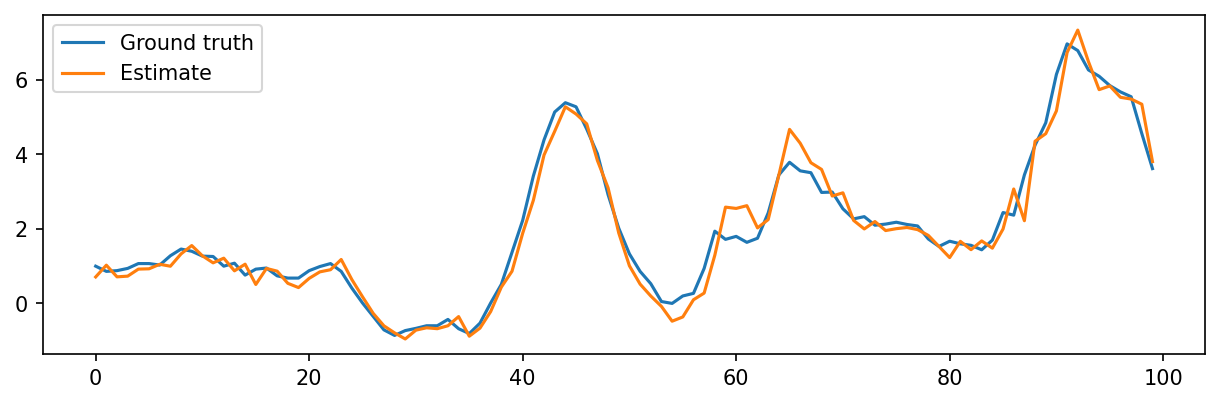

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,3), dpi=150)
plt.plot(y_test[T:100+T].values)
estimated = rnn_model.predict(dataset_test)
plt.plot(estimated[:100])
plt.legend(['Ground truth', 'Estimate'])